# Parameter Tuning
    Find best size for test set

In [3]:
!pip install pandas
!pip install sklearn

import pandas as pd;
import numpy as np;
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.svm import SVR

# empty list to append metric values
mae_gen = []
rmse_gen = []
mae_nor = []
mae_spi = []
rmse_nor = []
rmse_spi = []

In [5]:
test_set_range = [0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25]

for i in test_set_range:
    # import data
    data = pd.read_csv('Data_set_1_smaller.csv', index_col = 0)

    # 2018 data
    data = data.loc[data.index > 2018070000, :]

    # reset index
    data.reset_index(inplace = True)
    data.drop('index', axis = 1, inplace = True)

    # Divide features and labels
    X = data.iloc[:, 0:15]
    y = data.loc[:, 'Offers']
    
    X.fillna(X.median(), inplace = True)
    y.fillna(y.median(), inplace = True)

    X = X.round(20)
    
    # divide data into train and test with X test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size = i, 
                                                        shuffle=False)

    # feature scaling
    sc_X = MinMaxScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)
    
    # create regressor 
    regressor = SVR()
    regressor.fit(X_train, y_train)

    # predict for X_test  
    y_pred = regressor.predict(X_test)
    
    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    rmse_error = mse(y_test, y_pred, squared = False)
    mae_error = mae(y_test, y_pred)
    
    rmse_gen.append(rmse_error)
    mae_gen.append(mae_error)
    
    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================
    
    y_spike_occ = pd.read_csv('Spike_binary_1std.csv', usecols = [6])
    
    # create array same size as y_test
    y_spike_occ = y_spike_occ.iloc[- len(y_test):]
    y_spike_occ = pd.Series(y_spike_occ.iloc[:,0]).values
    
    
    # smal adjustment
    y_test.replace(0, 0.0001,inplace = True)

    
    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]
    
    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mae_spike = mae(y_test_spike, y_pred_spike)
    
    rmse_spi.append(rmse_spike)
    mae_spi.append(mae_spike)
    
    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================
    
    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)
    
    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 
    
    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]
    
    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mae_normal = mae(y_test_normal, y_pred_normal)
    
    rmse_nor.append(rmse_normal)
    mae_nor.append(mae_normal)

/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [6]:
data.head()

,Ren_R,APXP,Rene,TSDF,NIV,Im_Pr,In_gen,LOLP,PrevDay,PrevWeek,DA_margin,DA_imb,DA_price_france,ratio_offers_vol,DA_imb_France,Offers
0,0.600127,54.00,6908.443,21047.0,671.4654,74.81602,2722.0,0.0,130.0,118.0,25598.0,140.0,21.44,0.013304,0.775652,115.0
1,0.627876,47.20,6677.355,21256.0,403.5933,64.76704,2776.0,0.0,130.0,118.0,25551.0,-188.0,23.43,0.012274,0.743998,115.0
2,0.656457,47.20,6677.355,21146.0,225.2923,64.40000,2774.0,0.0,130.0,118.0,25459.0,-296.0,23.43,0.009810,0.743998,200.0
3,0.653530,42.99,6404.285,21203.0,171.2237,63.08086,2264.0,0.0,130.0,118.0,25031.0,-632.0,29.37,0.008795,0.740845,115.0
4,0.662001,42.99,6404.285,20928.0,84.9359,62.45185,2396.0,0.0,130.0,118.0,24933.0,-717.0,29.37,0.007537,0.740845,115.0


In [7]:
results = pd.DataFrame({                       
                        'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor}, index = test_set_range)

results

,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
0.050,29.712001,16.572219,71.424016,57.625163,12.982483,9.621456
0.075,28.055304,15.132729,69.362978,55.607667,11.778372,8.611372
0.100,31.388196,16.336174,80.479997,65.649883,12.479043,8.887749
0.125,31.996883,17.078261,82.214338,67.990672,13.085929,9.510200
0.150,32.258778,17.174818,82.546071,68.466244,12.985808,9.427676
0.175,31.602615,17.290274,76.808487,62.815986,12.805893,9.536084
0.200,30.702734,17.510302,73.070398,59.187557,13.184578,10.222324
0.225,41.229824,20.470532,94.713206,68.303457,18.611939,11.566074
0.250,39.662078,19.742893,90.609789,64.708769,17.986125,11.277021


In [8]:
!pip install matplotlib

%matplotlib notebook

import matplotlib.pyplot as plt

In [9]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
0.05,29.712001,16.572219,71.424016,57.625163,12.982483,9.621456
0.075,28.055304,15.132729,69.362978,55.607667,11.778372,8.611372
0.1,31.388196,16.336174,80.479997,65.649883,12.479043,8.887749
0.125,31.996883,17.078261,82.214338,67.990672,13.085929,9.510200
0.15,32.258778,17.174818,82.546071,68.466244,12.985808,9.427676
0.175,31.602615,17.290274,76.808487,62.815986,12.805893,9.536084
0.2,30.702734,17.510302,73.070398,59.187557,13.184578,10.222324
0.225,41.229824,20.470532,94.713206,68.303457,18.611939,11.566074
0.25,39.662078,19.742893,90.609789,64.708769,17.986125,11.277021


<IPython.core.display.Javascript object>


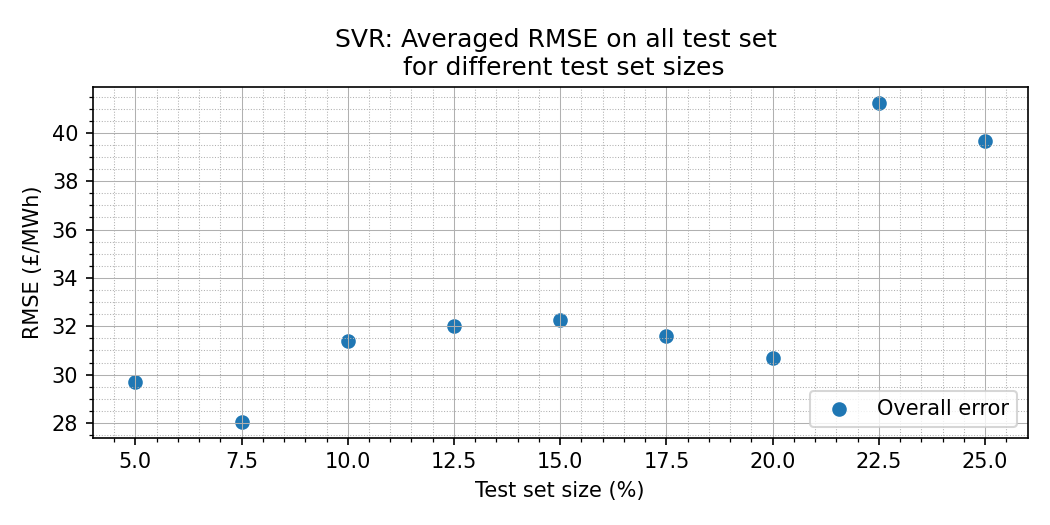

<IPython.core.display.Javascript object>


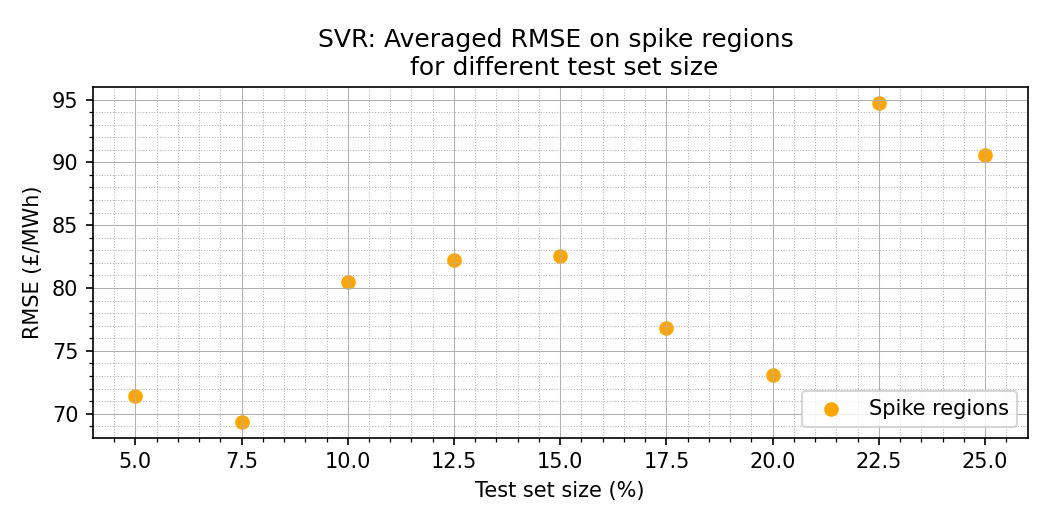

<IPython.core.display.Javascript object>


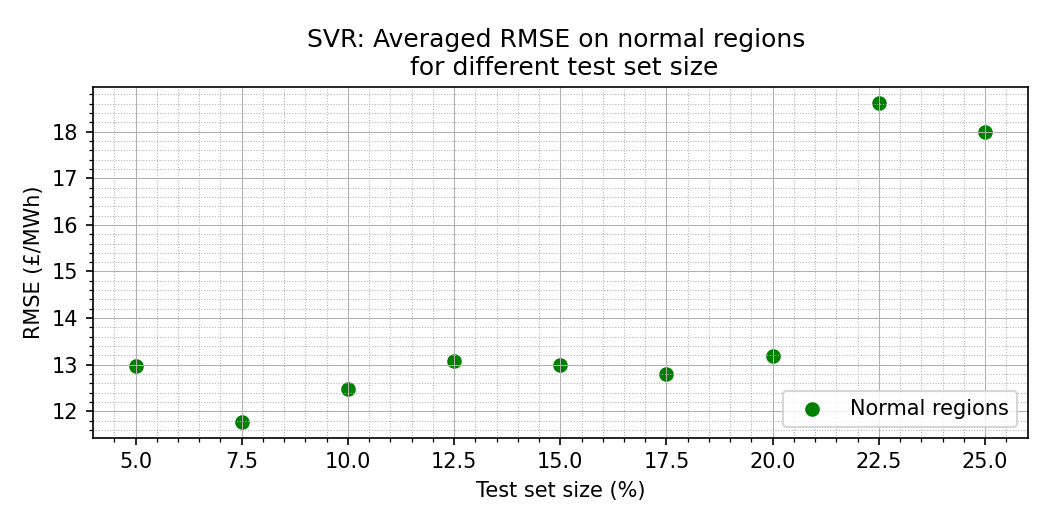

In [10]:
plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('SVR: Averaged RMSE on all test set \n for different test set sizes')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8], y = rmse_gen, label = 'Overall error')
plt.legend(loc = 'lower right')
plt.ylabel('RMSE (£/MWh)')
plt.xlabel('Test set size (%)')
a = []
for i in test_set_range:
    a.append(i * 100)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], a)
plt.tight_layout()
plt.savefig('RMSE_best_test_set_all.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('SVR: Averaged RMSE on spike regions \n for different test set size')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8], y =rmse_spi, label = 'Spike regions', color = 'orange')
plt.legend(loc = 'lower right')
plt.ylabel('RMSE (£/MWh)')
plt.xlabel('Test set size (%)')
a = []
for i in test_set_range:
    a.append(i * 100)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], a)
plt.tight_layout()
plt.savefig('RMSE_best_test_set_spike.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('SVR: Averaged RMSE on normal regions \n for different test set size')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8], y =rmse_nor, label = 'Normal regions', color = 'green')
plt.legend(loc = 'lower right')
plt.ylabel('RMSE (£/MWh)')
plt.xlabel('Test set size (%)')
a = []
for i in test_set_range:
    a.append(i * 100)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], a)
plt.tight_layout()
plt.savefig('RMSE_best_test_set_normal.png')

<IPython.core.display.Javascript object>


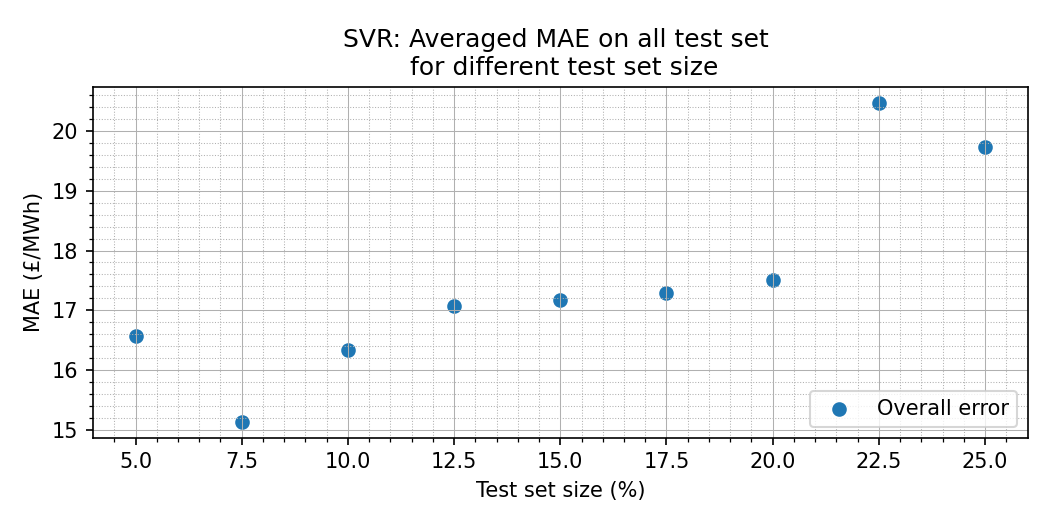

<IPython.core.display.Javascript object>


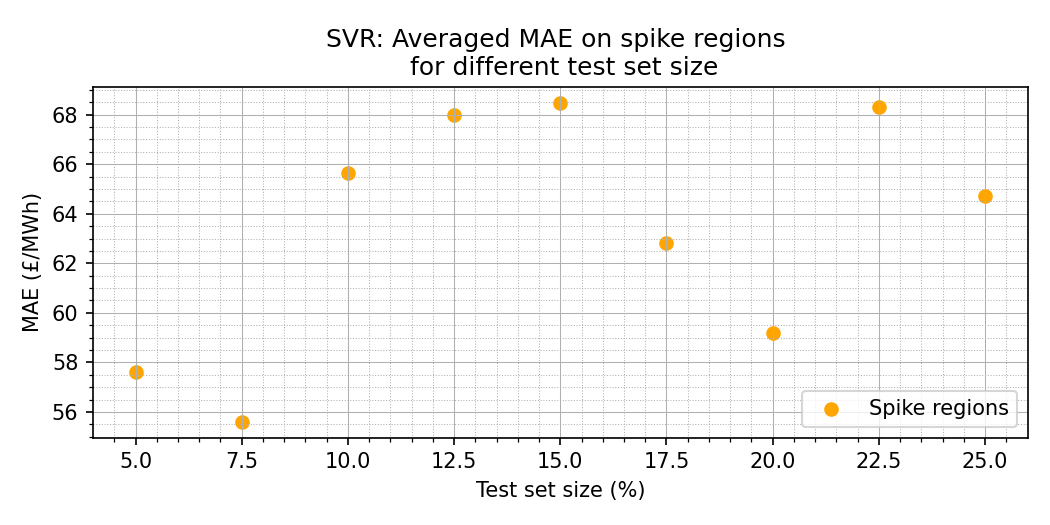

<IPython.core.display.Javascript object>


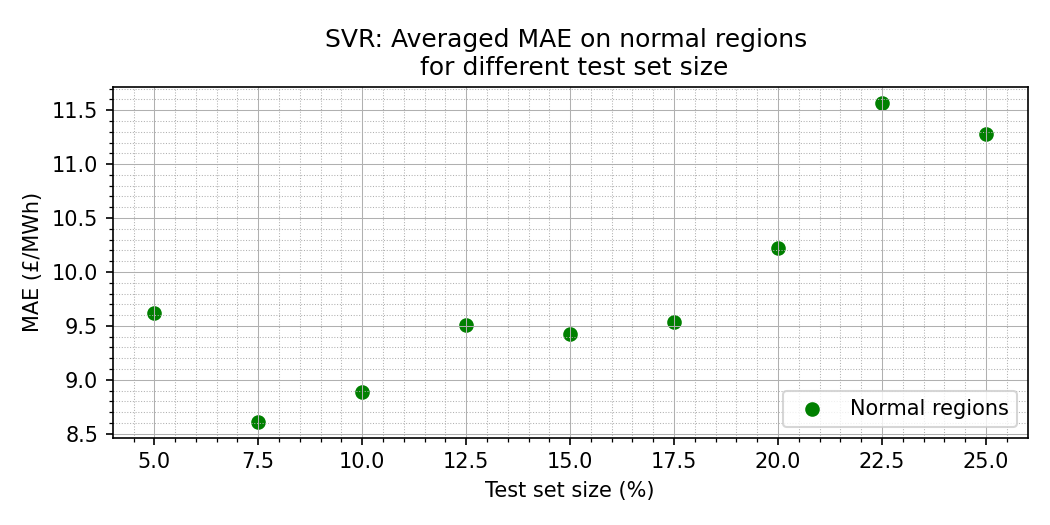

In [11]:
plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('SVR: Averaged MAE on all test set \n for different test set size')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8], y = mae_gen, label = 'Overall error')
plt.legend(loc = 'lower right')
plt.ylabel('MAE (£/MWh)')
plt.xlabel('Test set size (%)')
a = []
for i in test_set_range:
    a.append(i * 100)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], a)
plt.tight_layout()
plt.savefig('MAE_best_test_set_all.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('SVR: Averaged MAE on spike regions \n for different test set size')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8], y =mae_spi, label = 'Spike regions', color = 'orange')
plt.legend(loc = 'lower right')
plt.ylabel('MAE (£/MWh)')
plt.xlabel('Test set size (%)')
a = []
for i in test_set_range:
    a.append(i * 100)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], a)
plt.tight_layout()
plt.savefig('MAE_best_test_set_spike.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('SVR: Averaged MAE on normal regions \n for different test set size')
plt.scatter(x = [0, 1, 2, 3, 4, 5, 6, 7, 8], y = mae_nor, label = 'Normal regions', color = 'green')
plt.legend(loc = 'lower right')
plt.ylabel('MAE (£/MWh)')
plt.xlabel('Test set size (%)')
a = []
for i in test_set_range:
    a.append(i * 100)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], a)
plt.tight_layout()
plt.savefig('MAE_best_test_set_normal.png')